In [2]:
from google.colab import files
uploaded = files.upload()


Saving dataset.csv to dataset.csv


In [3]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Category10
output_notebook()


In [4]:
import pandas as pd

# Load the uploaded CSV file
df = pd.read_csv('dataset.csv')

# Display the first few rows
print("First 5 rows of the dataset:")
display(df.head())

# Display column info and check data types
print("\nDataset Info:")
df.info()

# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


First 5 rows of the dataset:


,ID,SystemCodeNumber,Capacity,Latitude,Longitude,Occupancy,VehicleType,TrafficConditionNearby,QueueLength,IsSpecialDay,LastUpdatedDate,LastUpdatedTime
0,0,BHMBCCMKT01,577,26.144536,91.736172,61,car,low,1,0,04-10-2016,07:59:00
1,1,BHMBCCMKT01,577,26.144536,91.736172,64,car,low,1,0,04-10-2016,08:25:00
2,2,BHMBCCMKT01,577,26.144536,91.736172,80,car,low,2,0,04-10-2016,08:59:00
3,3,BHMBCCMKT01,577,26.144536,91.736172,107,car,low,2,0,04-10-2016,09:32:00
4,4,BHMBCCMKT01,577,26.144536,91.736172,150,bike,low,2,0,04-10-2016,09:59:00



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18368 entries, 0 to 18367
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      18368 non-null  int64  
 1   SystemCodeNumber        18368 non-null  object 
 2   Capacity                18368 non-null  int64  
 3   Latitude                18368 non-null  float64
 4   Longitude               18368 non-null  float64
 5   Occupancy               18368 non-null  int64  
 6   VehicleType             18368 non-null  object 
 7   TrafficConditionNearby  18368 non-null  object 
 8   QueueLength             18368 non-null  int64  
 9   IsSpecialDay            18368 non-null  int64  
 10  LastUpdatedDate         18368 non-null  object 
 11  LastUpdatedTime         18368 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 1.7+ MB

Missing values in each column:
ID                        0
SystemCodeNu

In [5]:
# ✅ STEP 0: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
# ✅ STEP 1: Load and preprocess dataset
df = pd.read_csv("dataset.csv")

# Combine date and time columns into a Timestamp
df['Timestamp'] = pd.to_datetime(
    df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],
    dayfirst=True,
    errors='coerce'  # avoid parsing errors
)


In [7]:
# Drop missing timestamps
df = df.dropna(subset=['Timestamp'])
df = df.sort_values(by=['SystemCodeNumber', 'Timestamp']).reset_index(drop=True)


In [8]:
# ✅ STEP 2: Filter for a few parking lots for visualization
sample_lots = ['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01']
df_sample = df[df['SystemCodeNumber'].isin(sample_lots)].copy()


In [9]:
# Clean up TrafficConditionNearby and VehicleType columns BEFORE computing prices

# Step 1: Convert TrafficConditionNearby to lowercase strings
df_sample['TrafficConditionNearby'] = df_sample['TrafficConditionNearby'].astype(str).str.lower()

# Step 2: Map string values to numeric (low=1.0, medium=2.0, high=3.0)
traffic_map = {'low': 1.0, 'medium': 2.0, 'high': 3.0}
df_sample['TrafficConditionNearby'] = df_sample['TrafficConditionNearby'].map(traffic_map)

# Step 3: Fill missing or unexpected traffic values with medium = 2.0
df_sample['TrafficConditionNearby'] = df_sample['TrafficConditionNearby'].fillna(2.0)

# Step 4: Clean VehicleType column
df_sample['VehicleType'] = df_sample['VehicleType'].astype(str).str.lower()



In [10]:
# ✅ STEP 3: MODEL 1 – Linear Pricing based on Occupancy
base_price = 10
alpha = 5  # linear weight
df_sample['Price_Model1'] = base_price + alpha * (df_sample['Occupancy'] / df_sample['Capacity'])
df_sample['Price_Model1'] = df_sample['Price_Model1'].clip(5, 20)


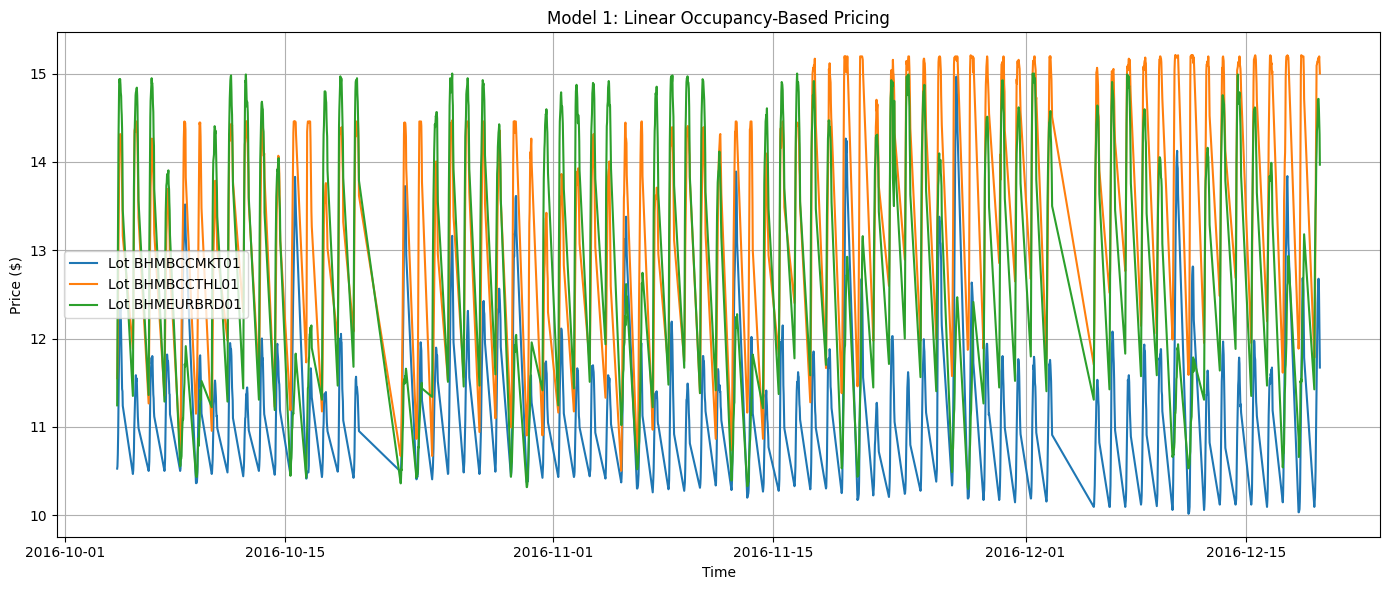

In [11]:
# ✅ STEP 4: Plot Model 1
plt.figure(figsize=(14, 6))
for lot in sample_lots:
    lot_data = df_sample[df_sample['SystemCodeNumber'] == lot]
    plt.plot(lot_data['Timestamp'], lot_data['Price_Model1'], label=f"Lot {lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title("Model 1: Linear Occupancy-Based Pricing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
# ✅ STEP 5: MODEL 2 – Demand-Based Pricing
# Define weights
alpha = 0.5   # Occupancy
beta = 0.2    # Queue length
gamma = 0.1   # Traffic
delta = 0.3   # Special Day
epsilon = 0.4 # Vehicle Type Weight


In [13]:


vehicle_weights = {'car': 1.0, 'bike': 0.7, 'truck': 1.3}

# --- Step 2: Clean traffic and vehicle type columns ---
# Safe lowercasing and mapping
df_sample['TrafficConditionNearby'] = df_sample['TrafficConditionNearby'].astype(str).str.lower()
df_sample['TrafficConditionNearby'] = df_sample['TrafficConditionNearby'].map({'low': 1.0, 'medium': 2.0, 'high': 3.0})
df_sample['TrafficConditionNearby'] = df_sample['TrafficConditionNearby'].fillna(2.0)  # fallback to medium
df_sample['VehicleType'] = df_sample['VehicleType'].astype(str).str.lower()

# --- Step 3: Compute demand scores ---
demand_scores = []

for idx, row in df_sample.iterrows():
    try:
        occupancy_rate = row['Occupancy'] / row['Capacity']
        queue = row['QueueLength']
        traffic = row['TrafficConditionNearby']
        is_special = row['IsSpecialDay']
        vehicle_type = row['VehicleType']
        vweight = vehicle_weights.get(vehicle_type, 1.0)

        demand = (
            alpha * occupancy_rate +
            beta * queue -
            gamma * traffic +
            delta * is_special +
            epsilon * vweight
        )
        demand_scores.append(demand)
    except Exception as e:
        print(f"Error in row {idx}: {e}")
        demand_scores.append(0)

df_sample['DemandScore'] = demand_scores

# --- Step 4: Normalize demand to generate prices ---
min_d = df_sample['DemandScore'].min()
max_d = df_sample['DemandScore'].max()

if max_d - min_d == 0:
    df_sample['Price_Model2'] = 12  # fallback price
else:
    df_sample['Price_Model2'] = 10 + (df_sample['DemandScore'] - min_d) / (max_d - min_d) * 10


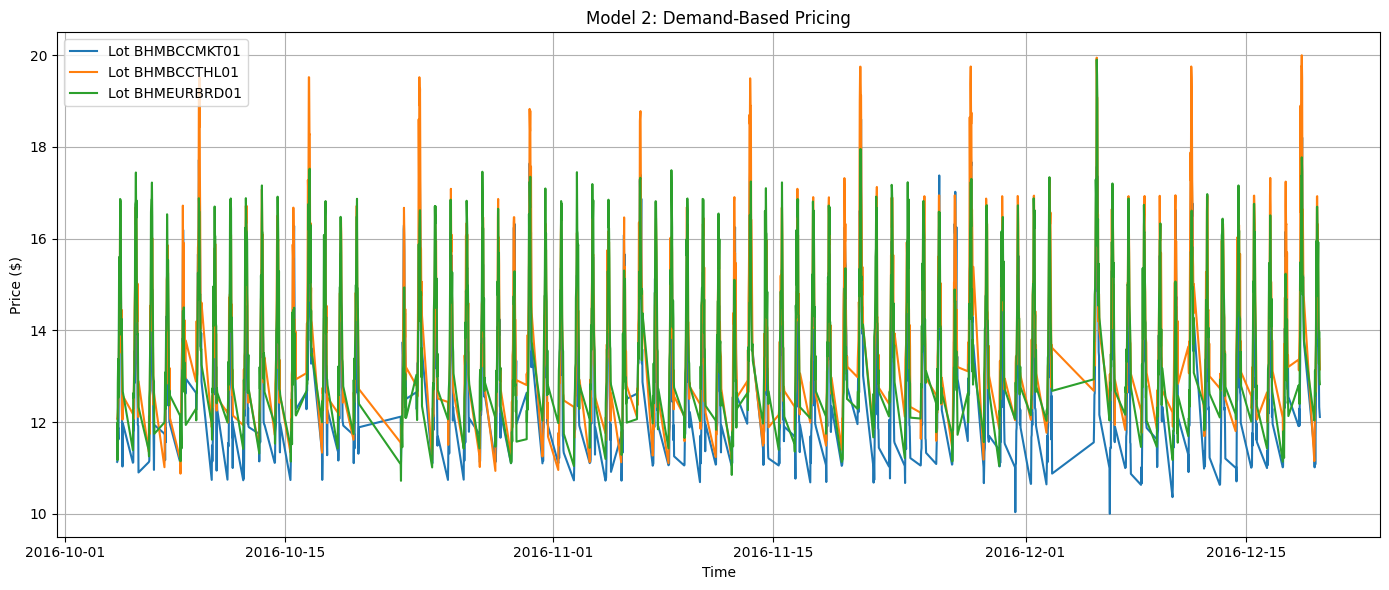

In [14]:
plt.figure(figsize=(14, 6))
for lot in sample_lots:
    lot_data = df_sample[df_sample['SystemCodeNumber'] == lot]
    plt.plot(lot_data['Timestamp'], lot_data['Price_Model2'], label=f"Lot {lot}")
plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title("Model 2: Demand-Based Pricing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
# Check Price_Model2 values after Model 2 calculations
df_sample[df_sample['SystemCodeNumber'].isin(sample_lots)][
    ['SystemCodeNumber', 'Timestamp', 'Price_Model2']
].head(10)


,SystemCodeNumber,Timestamp,Price_Model2
0,BHMBCCMKT01,2016-10-04 07:59:00,11.131915
1,BHMBCCMKT01,2016-10-04 08:25:00,11.140014
2,BHMBCCMKT01,2016-10-04 08:59:00,11.806291
3,BHMBCCMKT01,2016-10-04 09:32:00,11.879182
4,BHMBCCMKT01,2016-10-04 09:59:00,11.621418
5,BHMBCCMKT01,2016-10-04 10:26:00,12.691241
6,BHMBCCMKT01,2016-10-04 10:59:00,15.047724
7,BHMBCCMKT01,2016-10-04 11:25:00,14.126383
8,BHMBCCMKT01,2016-10-04 11:59:00,14.158779
9,BHMBCCMKT01,2016-10-04 12:29:00,15.673074


In [16]:
# Parameters
base_price = 10
alpha = 5     # Weight for demand
comp_weight = 0.3  # Influence of competing lots

# Initialize price column
df_sample['Price_Model3'] = 0.0

# Iterate over timestamps
for t in df_sample['Timestamp'].unique():
    time_slice = df_sample[df_sample['Timestamp'] == t]
    avg_price_other_lots = time_slice['Price_Model2'].mean()

    for idx, row in time_slice.iterrows():
        demand_score = row['DemandScore']
        comp_effect = avg_price_other_lots - row['Price_Model2']

        price = base_price + alpha * demand_score + comp_weight * comp_effect
        df_sample.at[idx, 'Price_Model3'] = round(price, 2)


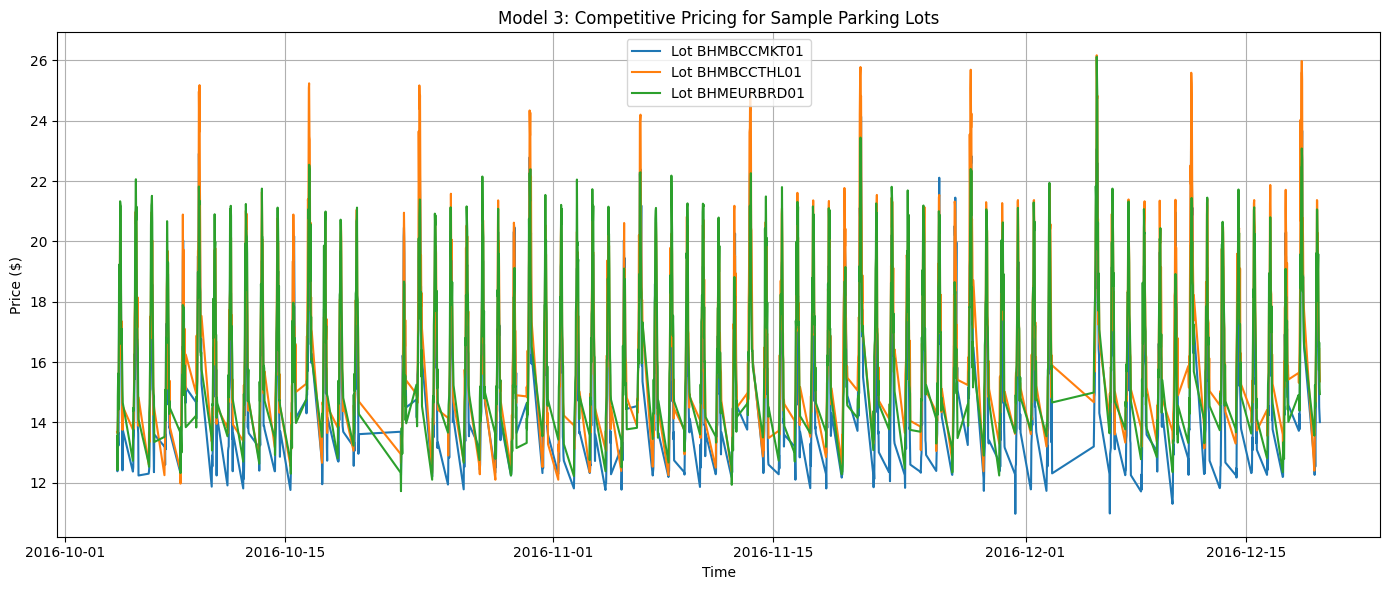

In [17]:
# ✅ Plot Model 3 (Competitive Pricing)
plt.figure(figsize=(14, 6))
for lot in sample_lots:
    lot_data = df_sample[df_sample['SystemCodeNumber'] == lot]
    plt.plot(lot_data['Timestamp'], lot_data['Price_Model3'], label=f"Lot {lot}")

plt.xlabel("Time")
plt.ylabel("Price ($)")
plt.title("Model 3: Competitive Pricing for Sample Parking Lots")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from bokeh.plotting import figure, show, output_notebook    #For BOKEH models
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Category10
output_notebook()

# Sample lots and colors
sample_lots = ['BHMBCCMKT01', 'BHMBCCTHL01', 'BHMEURBRD01']
colors = Category10[10]

# Bokeh figure
p = figure(x_axis_type='datetime', title="Model 1: Static Pricing (Bokeh)", height=400, width=800)
legend_items = []

# Add each lot's line to the plot
for i, lot in enumerate(sample_lots):
    lot_data = df_sample[df_sample['SystemCodeNumber'] == lot]
    source = ColumnDataSource(data={
        'x': lot_data['Timestamp'],
        'y': lot_data['Price_Model1']
    })
    line = p.line('x', 'y', source=source, color=colors[i], line_width=2)
    legend_items.append((f"Lot {lot}", [line]))

# Add legend
legend = Legend(items=legend_items, location="top_left")
p.add_layout(legend, 'right')
p.xaxis.axis_label = 'Time'
p.yaxis.axis_label = 'Price ($)'

# Show plot
show(p)



In [19]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Category10
output_notebook()

# Create Bokeh plot
p2 = figure(x_axis_type='datetime', title="Model 2: Demand-Based Pricing (Bokeh)", height=400, width=800)
legend_items_2 = []

# Loop through each sample lot
for i, lot in enumerate(sample_lots):
    lot_data = df_sample[df_sample['SystemCodeNumber'] == lot]
    source = ColumnDataSource(data={
        'x': lot_data['Timestamp'],
        'y': lot_data['Price_Model2']
    })
    line = p2.line('x', 'y', source=source, color=Category10[10][i], line_width=2)
    legend_items_2.append((f"Lot {lot}", [line]))

# Add legend and axis labels
legend2 = Legend(items=legend_items_2, location="top_left")
p2.add_layout(legend2, 'right')
p2.xaxis.axis_label = 'Time'
p2.yaxis.axis_label = 'Price ($)'

# Show the plot
show(p2)


In [20]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, Legend
from bokeh.palettes import Category10
output_notebook()

# Create Bokeh plot for Model 3
p3 = figure(x_axis_type='datetime', title="Model 3: Competitive Pricing (Bokeh)", height=400, width=800)
legend_items_3 = []

# Loop through each sample lot and plot
for i, lot in enumerate(sample_lots):
    lot_data = df_sample[df_sample['SystemCodeNumber'] == lot]
    source = ColumnDataSource(data={
        'x': lot_data['Timestamp'],
        'y': lot_data['Price_Model3']
    })
    line = p3.line('x', 'y', source=source, color=Category10[10][i], line_width=2)
    legend_items_3.append((f"Lot {lot}", [line]))

# Add legend and labels
legend3 = Legend(items=legend_items_3, location="top_left")
p3.add_layout(legend3, 'right')
p3.xaxis.axis_label = 'Time'
p3.yaxis.axis_label = 'Price ($)'

# Show plot
show(p3)


In [21]:
# Save sample with pricing columns to CSV
df_sample.to_csv('final_parking_pricing.csv', index=False)
